# Single channel denoising

first some import, settings, and utilities

In [1]:
import sys
import os
sys.path.append("..")

import IPython
import pyroomacoustics as pra
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['font.size'] = 40
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15


def plot_spec(noisy_signal, denoised_signal, clean_signal=None):
    noisy_signal = noisy_signal / np.abs(noisy_signal).max()
    denoised_signal = denoised_signal / np.abs(denoised_signal).max()
    
    if clean_signal is not None:
        clean_signal = clean_signal / np.abs(clean_signal).max()
        n_figs = 3
    else:
        n_figs = 2
            
    min_val = -80
    max_val = -40
    plt.figure(figsize=(20,10))
    plt.subplot(n_figs, 1, 1)
    plt.specgram(noisy_signal, NFFT=256, Fs=fs,
                 vmin=min_val, vmax=max_val)
    plt.title('Noisy')
    plt.subplot(n_figs, 1, 2)
    plt.specgram(denoised_signal, NFFT=256, Fs=fs,
                 vmin=min_val, vmax=max_val)
    plt.title('Denoised')
    
    if clean_signal is not None:
        plt.subplot(n_figs, 1, 3)
        plt.specgram(clean_signal, NFFT=256, Fs=fs,
                     vmin=min_val, vmax=max_val)
        plt.title('Clean')
        plt.tight_layout(pad=0.5)
        
    plt.show()
    

### Create noisy signal

In [2]:
SNR = 5        # dB
offset = 0.2   # seconds of noise before starting signal

# Clean signal
signal_fp = "arctic_a0010.wav"

# create noisy signal
noise_fp = "exercise_bike.wav"
noisy_signal, clean_signal, noise, fs = pra.create_noisy_signal(signal_fp, snr=SNR, noise_fp=noise_fp, offset=offset)
offset_samp = int(offset * fs)

IPython.display.Audio(noisy_signal, rate=fs)

/Users/eric/GITHUB/pyroomacoustics/pra_dev/lib/python2.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


### Clean signal for reference

In [3]:
IPython.display.Audio(clean_signal, rate=fs)

# SPECTRAL SUBTRACTION

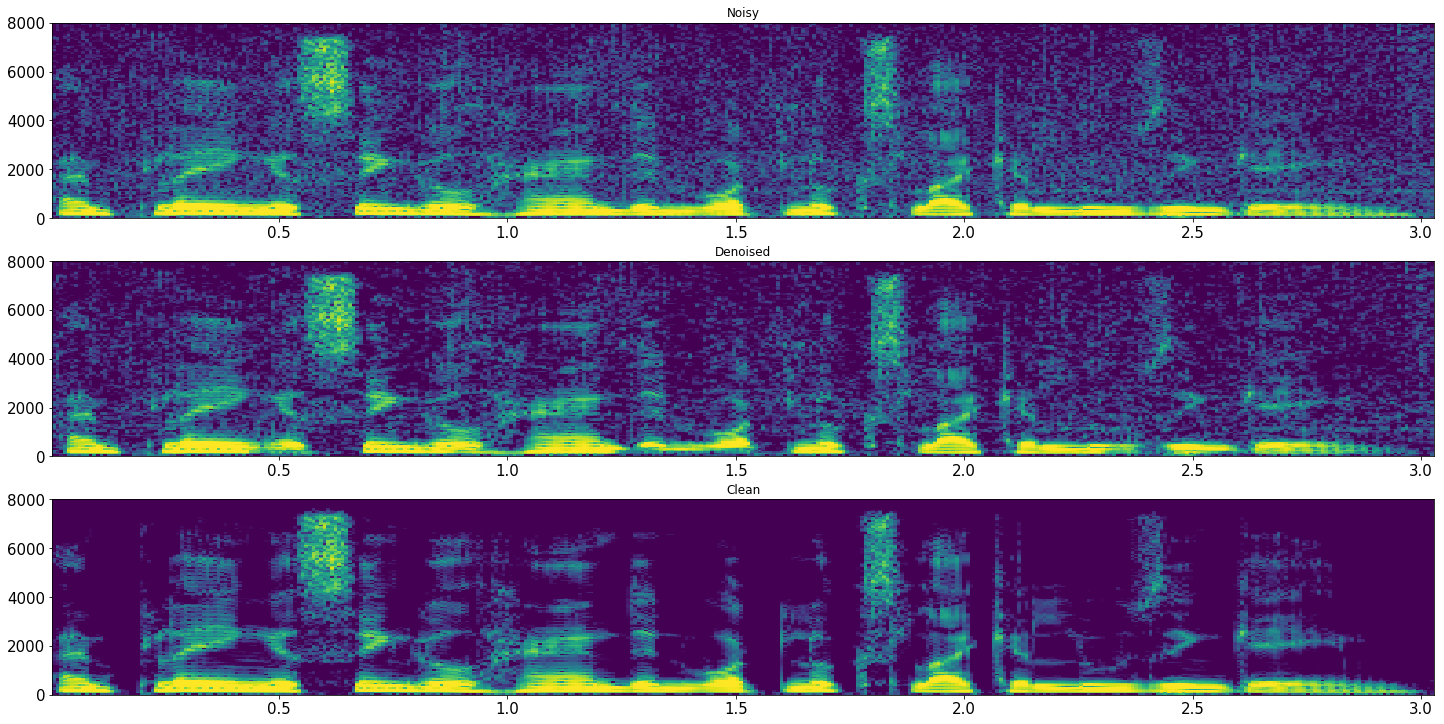

In [4]:
from pyroomacoustics.denoise import apply_spectral_sub

denoised_spectral_sub = apply_spectral_sub(noisy_signal, 
                                           nfft=512, 
                                           db_reduc=10,       # max suppression, higher value --> more suppression but also distortion
                                           lookback=12,       # how many frames (nfft/2) to look back
                                           beta=3,            # higher value --> more suppression but also distortion
                                           alpha=1.2)         # higher value --> more suppression but also distortion

plot_spec(noisy_signal[offset_samp:], denoised_spectral_sub[offset_samp:], clean_signal)

# Denoised
IPython.display.Audio(denoised_spectral_sub[offset_samp:], rate=fs)

In [5]:
# Noisy signal
IPython.display.Audio(noisy_signal, rate=fs)

not much improvement

TODO:
- smoothen spectrum so don't have abrupt peaks
- dual time contant method for tracking noise floor

# ITERATIVE WIENER FILTERING

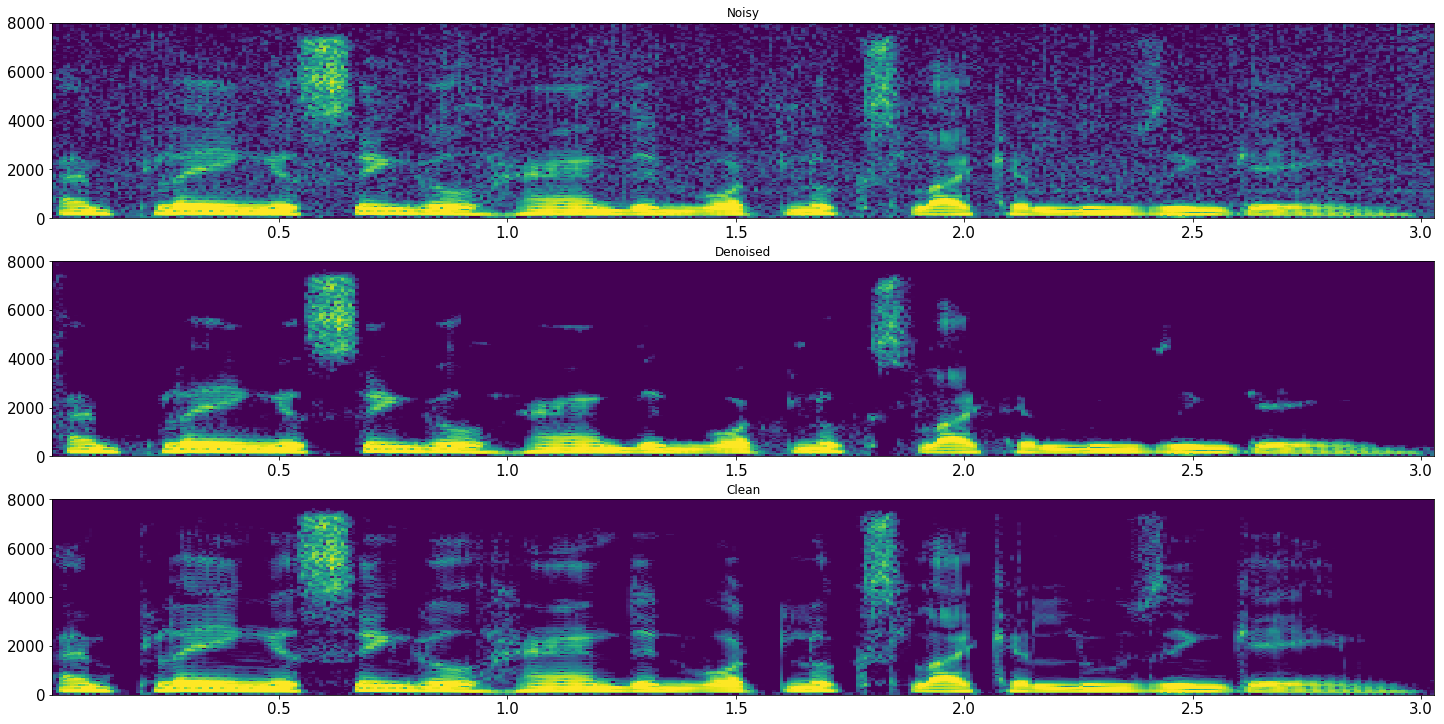

In [6]:
from pyroomacoustics.denoise import apply_iterative_wiener

denoised_iter_wiener = apply_iterative_wiener(noisy_signal,
                                              frame_len=512,
                                              lpc_order=15,
                                              iterations=2,    # 2-4 is best, more iterations --> more suppression but also distortion
                                              alpha=0.1,       # lower value put more weight on new estimate --> tracks noise floor faster
                                              thresh=0.003)    # threshold for VAD, higher value may reject signal

plot_spec(noisy_signal[offset_samp:], denoised_iter_wiener[offset_samp:], clean_signal)

# Denoised
IPython.display.Audio(denoised_iter_wiener[offset_samp:], rate=fs)

In [7]:
# Original signal for comparison
IPython.display.Audio(noisy_signal, rate=fs)

TODO:
- better processing of noise frames
- high frequencies are severely attenuated due to cheap VAD

# SUBSPACE APPROACH

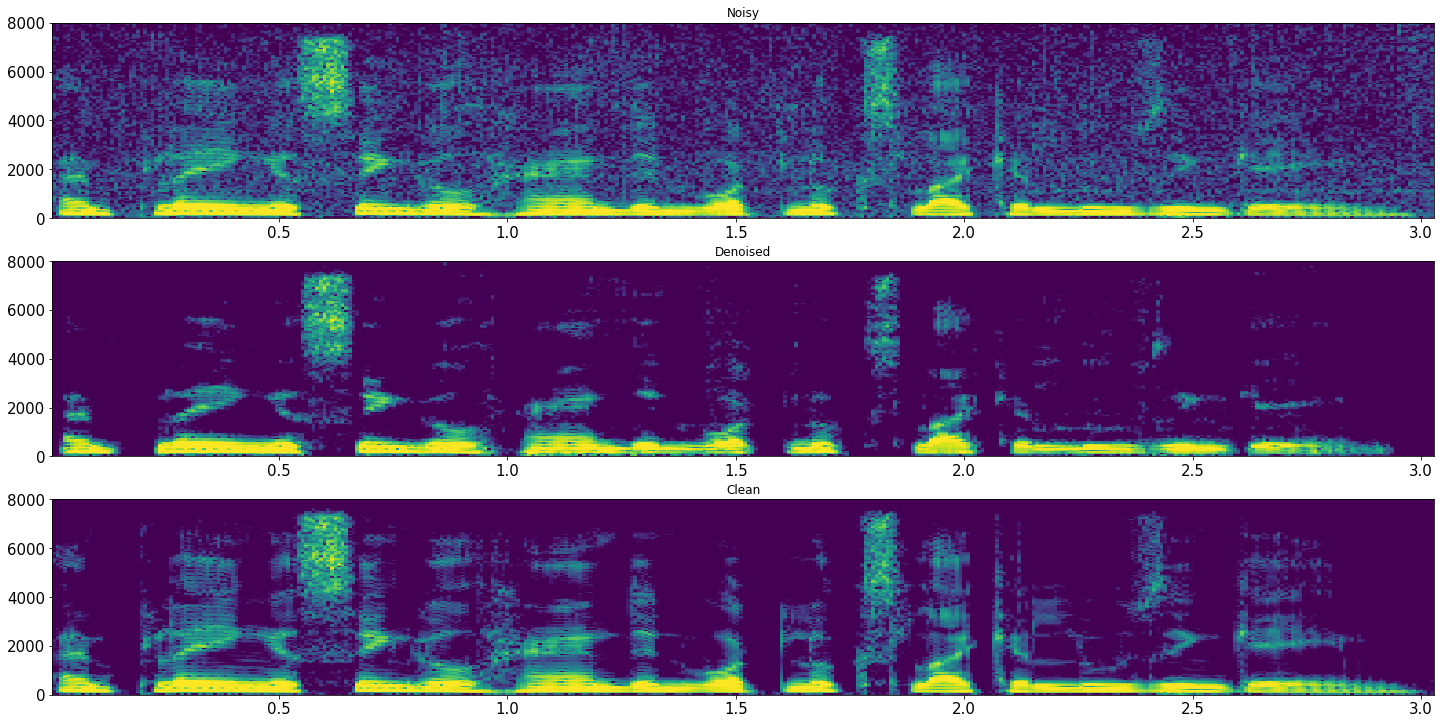

In [8]:
from pyroomacoustics.denoise import apply_subspace

denoised_subspace = apply_subspace(noisy_signal,
                                   frame_len=80,
                                   mu=10,          # higher value --> more suppression but also distortio 
                                   lookback=10,    # how many frames (frame_len/2) to look back
                                   skip=1,         # how many samples to skip in cov estimation, more skip --> faster but worse estimate
                                   thresh=0.003,   # threshold for VAD, higher value may reject signal
                                   data_type=np.float32)     # process with float32 for speech

plot_spec(noisy_signal[offset_samp:], denoised_subspace[offset_samp:], clean_signal)

# Denoised
IPython.display.Audio(denoised_subspace[offset_samp:], rate=fs)

In [9]:
# Noisy signal
IPython.display.Audio(noisy_signal, rate=fs)

Preserves higher frequencies better. But slower method due to building covariance matrices and eigendecomposition.